In [1]:
import torch
from model import Encoder, cp_2_key_model, cp_2_k_mask
from config import args
from dataset import Enigma_simulate_c_2_p, Enigma_simulate_cp_2_k_limited, Enigma_simulate_cp_2_k
from torch.utils.data import DataLoader
import math
from torchsummary import summary
from tqdm import tqdm

Copying the compiled weight to regular models

In [2]:
# Load trained model's weights and config
ckpt = torch.load('CP2K_RNN_ENC_ckpt.pt')
ckpt_args = ckpt['args']

# Initialize new model by configs
model = cp_2_k_mask(args=ckpt_args, out_channels=26)
model.to('cuda')
model.eval()

weights = []
for k, v in ckpt['weights'].items():
    weights.append(v)

for idx, (k, v) in enumerate(model.state_dict().items()):
    # Copying weights
    # We have to copying like this, i am so confused
    v *= 0
    v += weights[idx].detach()

Running a mini batch of examples

In [3]:
dataset = Enigma_simulate_cp_2_k_limited(args=args)
dataloader = DataLoader(
        dataset=dataset,
        batch_size=512,
        collate_fn=dataset.collate_fn_padding,
        shuffle=True
    )

for inputs, targets, masks in dataloader:
    inputs, targets, masks = inputs.to('cuda'), targets.to('cuda'), masks.to('cuda')


    outputs = model(inputs, masks)

    print(f"Input shape: {inputs.shape}\nTarget shape: {targets.shape}\nMask shape: {masks.shape}\nOutput shape: {outputs.shape}")
    # print(masks, targets[1][~masks.T].shape, outputs[1][~masks.T].shape)
    break

true_positive = 0
samples = 0

outputs_indices = torch.argmax(outputs, dim=-1) # -> [rotor, seq, batch]
for rotor in range(outputs_indices.shape[0]):
    mask = outputs_indices[rotor][~masks.T] == targets[rotor][~masks.T]
    true_positive += mask.sum()
    samples += math.prod(mask.shape)

print(f"Acc: {true_positive / samples}")

Input shape: torch.Size([30, 512, 52])
Target shape: torch.Size([3, 30, 512])
Mask shape: torch.Size([512, 30])
Output shape: torch.Size([3, 30, 512, 26])
Acc: 0.9988064765930176


In [4]:
# Make prediction based on user's inputs
inputs, masks = dataset.cipher_plain_text_2_tensor('VMPDTAJYTXDZNEFOSOTPJOYSMOEBNX', 'WEARETHECHAMPIONANDTHEBESTPLAY') # Predict on usr inputs
inputs, masks = inputs.to('cuda'), masks.to('cuda')

with torch.no_grad():
    outputs = model(inputs, masks).argmax(dim=-1).squeeze(-1) # -> shape [rotor, seq]
print(f"Prediction: {chr(ord('A') + outputs[0, 0])}"
      f"{chr(ord('A') + outputs[1, 0])}"
      f"{chr(ord('A') + outputs[2, 0])}")

Prediction: AES


In [5]:
# Testint accuracy in different length
testing_args = args
results = {}


for length in range(5, 30):
    testing_args['SEQ_LENGTH'] = [length, length]
    dataset = Enigma_simulate_cp_2_k_limited(args=testing_args, mode='test')
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=1024,
        collate_fn=dataset.collate_fn_padding,
        shuffle=False,
        drop_last=False
    )

    # Tracking
    true_positive = 0
    samples = 0

    bar = tqdm(dataloader, leave=True)
    bar.set_description_str(f"Length: {length}")

    for inputs, targets, masks in bar:
        inputs, targets, masks = inputs.to('cuda'), targets.to('cuda'), masks.to('cuda')

        # Making prediction
        # with torch.cuda.amp.autocast():
        with torch.no_grad():
            outputs = model(inputs, masks)

            # Compute accuracy
            outputs_indices = torch.argmax(outputs, dim=-1) # -> [rotor, seq, batch]
            for rotor in range(outputs_indices.shape[0]):
                mask = outputs_indices[rotor][~masks.T] == targets[rotor][~masks.T]
                true_positive += mask.sum()
                samples += math.prod(mask.shape)

        # Set bar's postfix
        bar.set_postfix_str(f"Acc: {(true_positive / samples).item()}")

    # Output and record the result
    results[length] = (true_positive / samples).item()
    print(f"Acc: {true_positive / samples}")

Length: 5: 100%|██████████| 35/35 [00:04<00:00,  7.39it/s]


Acc: 0.0918278694152832


Length: 6: 100%|██████████| 35/35 [00:06<00:00,  5.65it/s]


Acc: 0.12585817277431488


Length: 7: 100%|██████████| 35/35 [00:06<00:00,  5.13it/s]


Acc: 0.1746632307767868


Length: 8: 100%|██████████| 35/35 [00:06<00:00,  5.19it/s]


Acc: 0.23262310028076172


Length: 9: 100%|██████████| 35/35 [00:07<00:00,  4.85it/s]


Acc: 0.31527945399284363


Length: 10: 100%|██████████| 35/35 [00:06<00:00,  5.11it/s]


Acc: 0.411990761756897


Length: 11: 100%|██████████| 35/35 [00:07<00:00,  4.64it/s]


Acc: 0.5004810094833374


Length: 12: 100%|██████████| 35/35 [00:08<00:00,  4.35it/s]


Acc: 0.5696949362754822


Length: 13: 100%|██████████| 35/35 [00:10<00:00,  3.40it/s]


Acc: 0.6220749616622925


Length: 14: 100%|██████████| 35/35 [00:09<00:00,  3.84it/s]


Acc: 0.6693949699401855


Length: 15: 100%|██████████| 35/35 [00:08<00:00,  4.04it/s]


Acc: 0.719672679901123


Length: 16: 100%|██████████| 35/35 [00:08<00:00,  4.02it/s]


Acc: 0.7701843976974487


Length: 17: 100%|██████████| 35/35 [00:09<00:00,  3.77it/s]


Acc: 0.8135414123535156


Length: 18: 100%|██████████| 35/35 [00:09<00:00,  3.78it/s]


Acc: 0.8535197377204895


Length: 19: 100%|██████████| 35/35 [00:09<00:00,  3.64it/s]


Acc: 0.8924151062965393


Length: 20: 100%|██████████| 35/35 [00:09<00:00,  3.54it/s]


Acc: 0.9287721514701843


Length: 21: 100%|██████████| 35/35 [00:10<00:00,  3.48it/s]


Acc: 0.959744930267334


Length: 22: 100%|██████████| 35/35 [00:10<00:00,  3.36it/s]


Acc: 0.9798088669776917


Length: 23: 100%|██████████| 35/35 [00:10<00:00,  3.32it/s]


Acc: 0.989845335483551


Length: 24: 100%|██████████| 35/35 [00:10<00:00,  3.24it/s]


Acc: 0.9940057396888733


Length: 25: 100%|██████████| 35/35 [00:11<00:00,  3.18it/s]


Acc: 0.9963889718055725


Length: 26: 100%|██████████| 35/35 [00:11<00:00,  3.11it/s]


Acc: 0.9973674416542053


Length: 27: 100%|██████████| 35/35 [00:11<00:00,  2.98it/s]


Acc: 0.9980373978614807


Length: 28: 100%|██████████| 35/35 [00:11<00:00,  2.93it/s]


Acc: 0.9984014630317688


Length: 29: 100%|██████████| 35/35 [00:12<00:00,  2.81it/s]

Acc: 0.9985520839691162


Ploting the results

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] [0.0918278694152832, 0.12585817277431488, 0.1746632307767868, 0.23262310028076172, 0.31527945399284363, 0.411990761756897, 0.5004810094833374, 0.5696949362754822, 0.6220749616622925, 0.6693949699401855, 0.719672679901123, 0.7701843976974487, 0.8135414123535156, 0.8535197377204895, 0.8924151062965393, 0.9287721514701843, 0.959744930267334, 0.9798088669776917, 0.989845335483551, 0.9940057396888733, 0.9963889718055725, 0.9973674416542053, 0.9980373978614807, 0.9984014630317688, 0.9985520839691162]


Text(0.5, 0, 'Length')

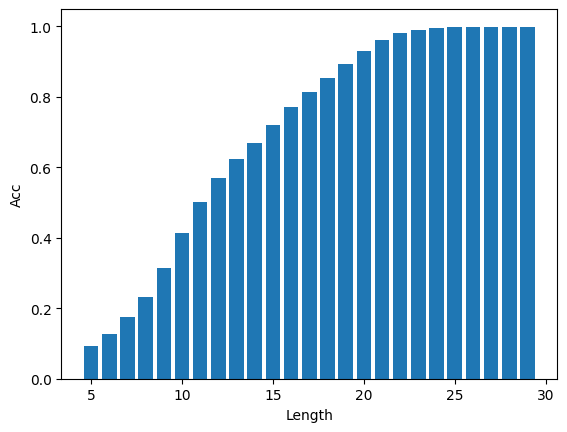

In [6]:
import matplotlib.pyplot as plt
x = list(results.keys())
y = list(results.values())

print(x, y)

fig, ax = plt.subplots()
ax.bar(x,height=y)
ax.set_ylabel('Acc')
ax.set_xlabel('Length')
# ax.plot(bins, y, '--')